In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import seaborn as sns
from copy import deepcopy
%config InlineBackend.figure_format = 'retina'
import numpy as np
from lifelines import CoxTimeVaryingFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from statsmodels.stats.multitest import multipletests
from collections import Counter
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Load MSK data

In [2]:
# read sample info
# remove samples without transplant day (missing data)
df_sample = pd.read_csv('../../data/MSKCC/tblASVsamples_FMTremoved.csv')
df_sample = df_sample[df_sample.DayRelativeToNearestHCT.notnull()]

# read body site decomposition of MSK data
df_relab = pd.read_csv('msk_nmf_decomposition.csv', index_col=0)
df_relab['Oral_cavity'] = df_relab['Oral_cavity_1'] + df_relab['Oral_cavity_2']

# read genus-level information
df_relab = pd.merge(df_relab,
                    pd.read_csv('../../data/MSKCC/tblrelab_closesthmptaxa.csv', index_col=0),
                    left_index=True,
                    right_index=True,
                    how='inner'
                   )

# read infection data
df_inf = pd.read_csv('../../data/MSKCC/tblInfectionsCidPapers_add_Strep.csv')
df_inf = df_inf[df_inf.DayRelativeToNearestHCT.notnull()] # remove patients with unknown HCT day

# Count distribution of bacterial infection records

In [3]:
pd.DataFrame.from_dict(dict(Counter(df_inf['InfectiousAgent'])), orient='index', columns=['NumberOfRecords']).sort_values(by='NumberOfRecords', ascending=False)

,NumberOfRecords
Enterococcus_Faecium_Vancomycin_Resistant,430
Escherichia,201
Klebsiella_Pneumoniae,190
Enterobacter,97
Pseudomonas,69
Enterococcus_Faecium,64
Stenotrophomonas_Maltophilia,61
Enterococcus_Faecalis,60
Streptococcus_Viridans_Group,31
Citrobacter,27


# SFig: half-life time of oral fraction decay

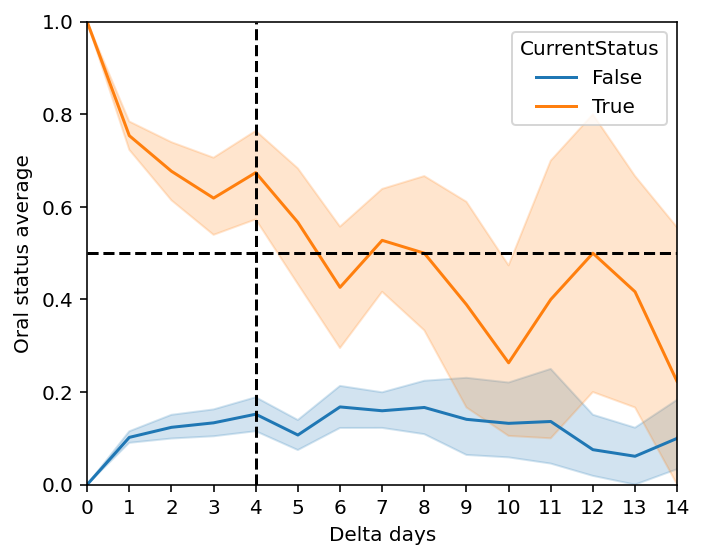

In [4]:
df_joint = pd.merge(df_sample.set_index('SampleID'), df_relab, left_index=True, right_index=True, how='inner')
df_joint['HighOral'] = df_joint['Oral_cavity']>=0.3
df_joint = df_joint[(df_joint.DayRelativeToNearestHCT>=-10) & (df_joint.DayRelativeToNearestHCT<=40)] # keep the same time window as used for cox model development

lines = []
for sampleID in df_joint.index:
    # current sample
    curr_pid = df_joint.loc[sampleID,'PatientID']
    curr_tps = df_joint.loc[sampleID,'Timepoint']
    curr_oral_status = df_joint.loc[sampleID,'HighOral']
    
    # find the next consecutive sample
    df_tmp = df_joint[(df_joint.PatientID==curr_pid) & (df_joint.Timepoint>curr_tps)]
    if len(df_tmp)>0:
        df_tmp = df_tmp.sort_values(by='Timepoint')
        next_tps = df_tmp.iloc[0].Timepoint
        next_oral_status = df_tmp.iloc[0].HighOral
        delta_days = next_tps-curr_tps
        lines.append([sampleID, delta_days, curr_oral_status, next_oral_status])
        lines.append([sampleID, 0, curr_oral_status, curr_oral_status]) # append information about current sample
df_oralstatus_decay = pd.DataFrame(lines, columns=['SampleID','DeltaDays','CurrentStatus','NextStatus'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
_ = sns.lineplot(x='DeltaDays', y='NextStatus', hue='CurrentStatus', data=df_oralstatus_decay, ax=ax)
_ = ax.set_xlabel('Delta days')
_ = ax.set_ylabel('Oral status average')
_ = ax.set_xlim([0,14])
_ = ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
_ = ax.set_ylim([0,1])
_ = ax.plot([0,14],[0.5,0.5],'k--')
_ = ax.plot([4,4],[0,1],'k--') # confidence interval is completely above 0.5

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("decay_of_oral_status.svg")

# Build univariable Cox model

In [5]:
def build_cox_model_input_table(infectious_agent,
                                study_start_day=-10,
                                study_stop_day=40,
                                min_samples_per_patient=2,
                                memory_duration=0  # note: this is the duration of a high oral state that is maintained (we assume infinite memory for low oral state)
                               ):
    lines = []
    for pid in set(df_sample.PatientID):
        df_sample_pid = df_sample[(df_sample.PatientID==pid)&(df_sample.DayRelativeToNearestHCT>=study_start_day)&(df_sample.DayRelativeToNearestHCT<=study_stop_day)].sort_values('Timepoint')
        if len(df_sample_pid) == 0:
            continue
        
        # check if the patient receives multiple HCT
        # treat each transplant as a new patient
        tps = list(df_sample_pid.Timepoint)
        days = list(df_sample_pid.DayRelativeToNearestHCT)
        break_tps = [tps[0]-1]
        for xt, yt, xd, yd in zip(tps, tps[1:], days, days[1:]):
            if yt-xt != yd-xd:
                break_tps.append(xt)
        break_tps.append(tps[-1])

        # break_tps = [tp1, tp2, tp3, ...]
        # periods include (tp1, tp2], (tp2, tp3], ...
        for tps_from, tps_to in zip(break_tps, break_tps[1:]):
            df_sample_tmp = df_sample_pid[(df_sample_pid.Timepoint>tps_from) & (df_sample_pid.Timepoint<=tps_to)]

            # skip if the current transplant period has fewer than min_samples_per_patient samples
            if len(df_sample_tmp)<min_samples_per_patient:
                continue
            else:
                first_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[0])
                last_sample_day = int(list(df_sample_tmp.DayRelativeToNearestHCT)[-1])
                assert first_sample_day < last_sample_day

            # find first infection (use timepoint to filter)
            df_inf_tmp = df_inf[(df_inf.PatientID==pid) & (df_inf.InfectiousAgent.str.contains('|'.join(infectious_agent))) & (df_inf.Timepoint>tps_from) & (df_inf.Timepoint<=tps_to)]
            df_inf_tmp = df_inf_tmp[(df_inf_tmp.DayRelativeToNearestHCT>first_sample_day) & (df_inf_tmp.DayRelativeToNearestHCT<=last_sample_day)]
            if len(df_inf_tmp) == 0:
                # no infection detected, set first infection day as the day of the last sample (censoring time)
                first_infection_day = last_sample_day
                infection_event = 0
            else:
                df_inf_tmp = df_inf_tmp.sort_values(by='DayRelativeToNearestHCT')
                first_infection_day = list(df_inf_tmp.DayRelativeToNearestHCT)[0]
                infection_event = 1
            assert first_infection_day > first_sample_day

            # use oral bacteria percentage as a covariant
            df_relab_tmp = df_relab.loc[list(df_sample_tmp.SampleID), 'Oral_cavity'].to_frame()>=0.3
            df_relab_tmp = df_relab_tmp[(df_relab_tmp.T != 0).any()] # remove rows that are only zero (i.e, remove samples not dominated by any ASV of the interesting genus)
            if len(df_relab_tmp) >0:
                domination_days = [int(v) for v in list(df_sample_tmp.loc[df_sample_tmp.SampleID.isin(list(df_relab_tmp.index)), 'DayRelativeToNearestHCT'])] # days that the genus of interest dominates the sample
                nondomination_days = list(set([int(v) for v in list(df_sample_tmp.DayRelativeToNearestHCT)])-set(domination_days))
                #first_domination_day = sorted(domination_days)[0]
                curr_state = 0 
                if first_sample_day in domination_days:
                    prev_state = 1
                else:
                    prev_state = 0
                days_after_measurement = 0
                for day in np.arange(first_sample_day, first_infection_day):
                    # for each period (left, right]: left is exclusive, right is inclusive
                    left_day = day    # exclusive
                    right_day = day+1 # inclusive
                    is_dominated = int(right_day in domination_days)
                    not_dominated = int(right_day in nondomination_days)

                    # determine the current state
                    if is_dominated or not_dominated:
                        # sample was sequenced, either domination or non-domination
                        if is_dominated==1 and not_dominated==0:
                            curr_state = 1
                        elif is_dominated==0 and not_dominated==1:
                            curr_state = 0
                        else:
                            print('codes should not enter here!')
                            raise
                        days_after_measurement = 0 # reset the clock
                    else:
                        # sample was missing
                        # we only use memory to fill in missing values if previous state is dominated
                        # we assume memory is infinite if previous state is non-dominated
                        if prev_state==0:
                            curr_state=0
                        else:
                            if days_after_measurement>=memory_duration:
                                curr_state = 0
                            else:
                                curr_state = 1
                        days_after_measurement += 1

                    # add or merge a period
                    curr_line = [pid, left_day, right_day]
                    if (day == first_sample_day) or (curr_state != prev_state):
                        curr_line.append(curr_state)
                        if right_day == first_infection_day:
                            curr_line.append(infection_event)
                        else:
                            curr_line.append(0)
                        lines.append(curr_line)
                        prev_state = deepcopy(curr_state)
                    else:
                        # modify last entry in lines
                        last_line = lines[-1]
                        last_line[2] = right_day
                        if right_day == first_infection_day:
                            last_line[-1] = infection_event
                        else:
                            last_line[-1] = 0
                        lines[-1] = last_line
            else:
                lines.append([pid, first_sample_day, first_infection_day, 0, infection_event])

    df_cox = pd.DataFrame(lines, columns=['PatientID','StartDay','StopDay','Domination','Infection'])
    df_cox = df_cox.loc[:, (df_cox != 0).any(axis=0)] # remove columns that are only zero
    return df_cox

## SFig: Test memory effects

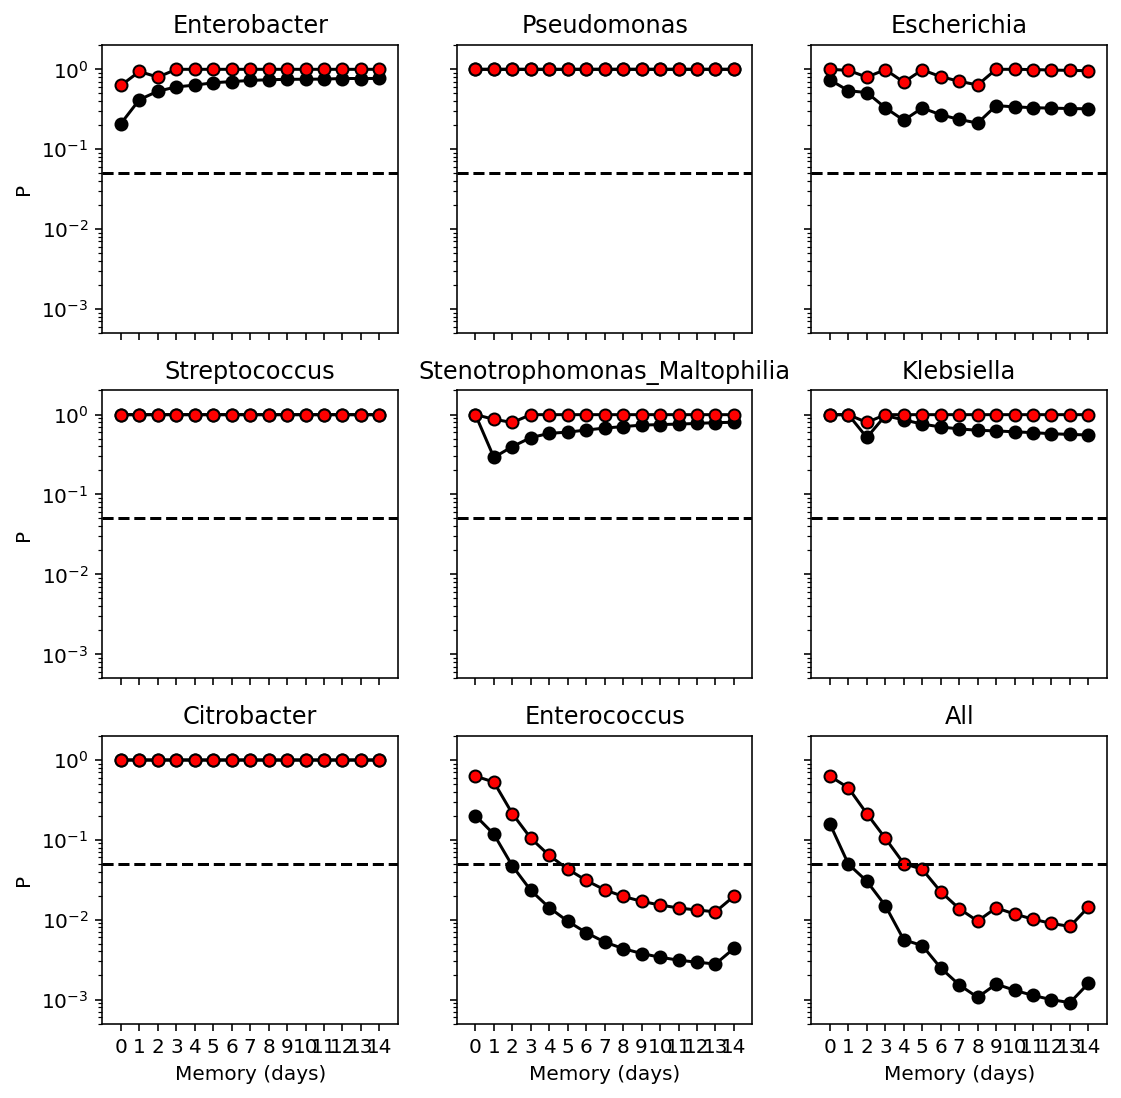

In [8]:
infectious_agents = ['Streptococcus',
                     'Enterococcus',
                     'Citrobacter',
                     'Enterobacter',
                     'Escherichia',
                     'Klebsiella',
                     'Pseudomonas',
                     'Stenotrophomonas_Maltophilia',
                     'All'
                    ]
lines = []
padjs = []
for m in np.arange(0,15):
    padjs_curr_agent = []
    for agent in infectious_agents:
        if agent == 'All':
            curr_df = build_cox_model_input_table(list(set(df_inf['InfectiousAgent'])), memory_duration=m)
        else:
            curr_df = build_cox_model_input_table([agent], memory_duration=m)
        curr_ctv = CoxTimeVaryingFitter(penalizer=0)
        curr_ctv.fit(curr_df, id_col="PatientID", event_col="Infection", start_col="StartDay", stop_col="StopDay", show_progress=False, step_size=0.1)
        curr_cox_summary = curr_ctv.summary[['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]
        padjs_curr_agent.append(curr_cox_summary.loc['Domination','p'])
        lines.append([agent,m]+list(curr_cox_summary.loc['Domination',['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]))
    padjs_curr_agent = multipletests(padjs_curr_agent, method='fdr_bh')[1]
    padjs.extend(padjs_curr_agent)
df_vary_memory = pd.DataFrame(lines, columns=['InfectiousAgent','Memory','HR','CI lower','CI upper','P'])
df_vary_memory['Padj'] = padjs

fig, ax = plt.subplots(figsize=(9,9), nrows=3, ncols=3, sharex=True, sharey=True)

for idx,agent in enumerate(set(df_vary_memory.InfectiousAgent)):
    row_idx = int(idx/3)
    col_idx = idx%3
    curr_df = df_vary_memory[df_vary_memory.InfectiousAgent==agent]
    _ = ax[row_idx,col_idx].plot(curr_df.Memory, curr_df.P, 'k-', marker='o', markersize=6, markerfacecolor='k')
    _ = ax[row_idx,col_idx].plot(curr_df.Memory, curr_df.Padj, 'k-', marker='o', markersize=6, markerfacecolor='r')
    _ = ax[row_idx,col_idx].plot([-1,15],[0.05,0.05],'k--')
    _ = ax[row_idx,col_idx].set_xlim([-1,15])
    _ = ax[row_idx,col_idx].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    _ = ax[row_idx,col_idx].set_yscale('log')
    _ = ax[row_idx,col_idx].set_ylim([0.0005, 2])
    _ = ax[row_idx,col_idx].set_title(agent)
    if row_idx==2:
        _ = ax[row_idx,col_idx].set_xlabel('Memory (days)')
    if col_idx==0:
        _ = ax[row_idx,col_idx].set_ylabel('P')

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("memory_effect_infection_oral.svg", format="svg")

# Fig3E: Plot harzard ratio using a memory of 4 days

In [6]:
infectious_agents = ['Streptococcus',
                     'Enterococcus',
                     'Citrobacter',
                     'Enterobacter',
                     'Escherichia',
                     'Klebsiella',
                     'Pseudomonas',
                     'Stenotrophomonas_Maltophilia'
                    ]
lines = []
for agent in infectious_agents:
    if agent == 'All':
        curr_df = build_cox_model_input_table(list(set(df_inf['InfectiousAgent'])), memory_duration=4)
    else:
        curr_df = build_cox_model_input_table([agent], memory_duration=4)
    curr_ctv = CoxTimeVaryingFitter(penalizer=0)
    curr_ctv.fit(curr_df, id_col="PatientID", event_col="Infection", start_col="StartDay", stop_col="StopDay", show_progress=False, step_size=0.1)
    lines.append([agent]+list(curr_ctv.summary.loc['Domination',['exp(coef)','exp(coef) lower 95%','exp(coef) upper 95%','p']]))
df_inf_oral_summary = pd.DataFrame(lines, columns=['InfectiousAgent','HR','CI lower','CI upper','P']).set_index('InfectiousAgent')
#df_inf_oral_summary['Padj'] = multipletests(df_inf_oral_summary.P, method='fdr_bh')[1]

# remove infections with insufficient data to support its correlation
df_inf_oral_summary = df_inf_oral_summary[df_inf_oral_summary['CI upper']!=np.inf]
df_inf_oral_summary = df_inf_oral_summary.sort_values('HR')
df_inf_oral_summary.to_csv('hazard_ratio_oral_fraction_bloodstream_infections.csv')
df_inf_oral_summary

,HR,CI lower,CI upper,P
InfectiousAgent,,,,
Enterococcus,0.233962,0.073338,0.746381,0.014121
Escherichia,0.565538,0.223358,1.431932,0.229166
Klebsiella,0.872067,0.195154,3.896923,0.857769
Enterobacter,1.752190,0.177451,17.301549,0.631193
Stenotrophomonas_Maltophilia,1.899934,0.194632,18.546507,0.580879


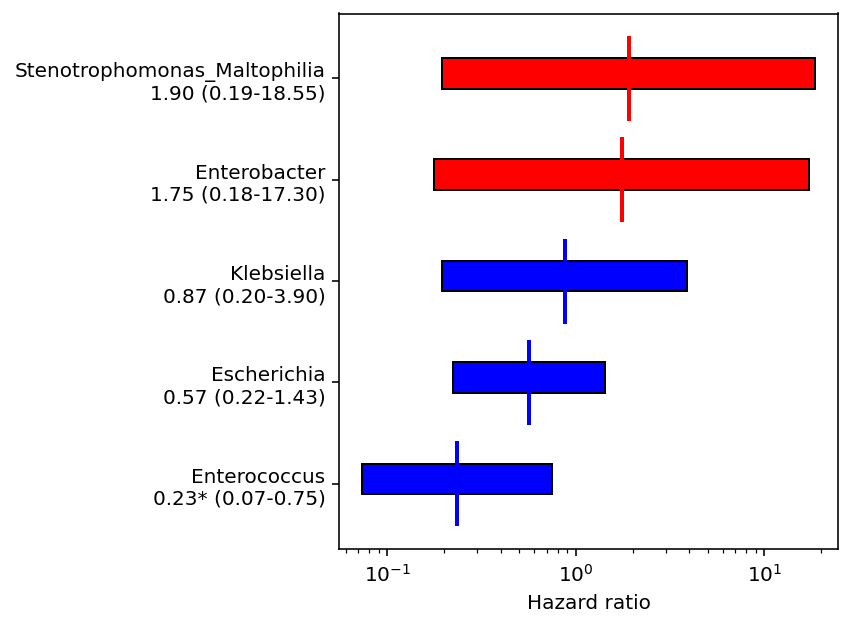

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))

yticks = []
yticklabels = []
for k, agent in enumerate(df_inf_oral_summary.index):
    hr = df_inf_oral_summary.loc[agent, 'HR']
    lower = df_inf_oral_summary.loc[agent, 'CI lower']
    higher = df_inf_oral_summary.loc[agent, 'CI upper']
    P = df_inf_oral_summary.loc[agent, 'P']
    
    # create a patch that represent CI
    if hr>1:
        facecolor='r'
    else:
        facecolor='b'
    rect = mpatches.Rectangle((lower, k-0.1), higher-lower, 0.3, linewidth=1, edgecolor='k', facecolor=facecolor)
    _ = ax.add_patch(rect)
    
    # plot HR
    _ = ax.plot([hr, hr],[k-0.4, k+0.4], linewidth=2, color=facecolor)
    
    # create P value notation
    # P < 0.05 *
    # P < 0.01 **
    # P < 0.001 ***
    # P < 0.0001 ****
    Psym = ''
    if P<0.0001:
        Psym = '****'
    elif P<0.001:
        Psym = '***'
    elif P<0.01:
        Psym = '**'
    elif P<0.05:
        Psym = '*'
    
    yticks.append(k)
    yticklabels.append('%s\n%2.2f%s (%2.2f-%2.2f)'%(agent, hr, Psym, lower, higher))

_ = ax.set_yticks(yticks)
_ = ax.set_yticklabels(yticklabels)
_ = ax.set_xlabel('Hazard ratio')
_ = ax.set_xscale('log')
#_ = ax.set_xlim([0,14])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("hazard_ratio_infection_oral_association.svg")

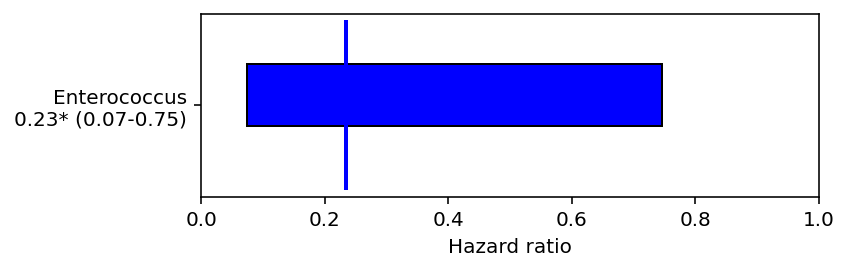

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))

hr = df_inf_oral_summary.loc['Enterococcus', 'HR']
lower = df_inf_oral_summary.loc['Enterococcus', 'CI lower']
higher = df_inf_oral_summary.loc['Enterococcus', 'CI upper']
P = df_inf_oral_summary.loc['Enterococcus', 'P']
    
# create a patch that represent CI
if hr>1:
    facecolor='r'
else:
    facecolor='b'
rect = mpatches.Rectangle((lower, -0.1), higher-lower, 0.3, linewidth=1, edgecolor='k', facecolor=facecolor)
_ = ax.add_patch(rect)

# plot HR
_ = ax.plot([hr, hr],[-0.4, +0.4], linewidth=2, color=facecolor)

# create P value notation
# P < 0.05 *
# P < 0.01 **
# P < 0.001 ***
# P < 0.0001 ****
Psym = ''
if P<0.0001:
    Psym = '****'
elif P<0.001:
    Psym = '***'
elif P<0.01:
    Psym = '**'
elif P<0.05:
    Psym = '*'

yticks = [0]
yticklabels = ['%s\n%2.2f%s (%2.2f-%2.2f)'%('Enterococcus', hr, Psym, lower, higher)]

_ = ax.set_yticks(yticks)
_ = ax.set_yticklabels(yticklabels)
_ = ax.set_xlabel('Hazard ratio')
#_ = ax.set_xscale('log')
_ = ax.set_xlim([0.0,1])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("hazard_ratio_enterococcus_infection.svg")